<a id='sec0'></a>
# Evaluating RandomForest using SMOTE oversampled dataset

- Use RandomForestClassifier with max_depth=40
- Train the model on oversample set and test it on the imbalanced set with the original class ratio
- Do the above with multiple rounds of oversampling to make sure the results are similar
- Only 2016 data was used to keep the sample size manageable for computing

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import precision_recall_curve
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from collections import Counter

import my_scoring_functions as msf

%matplotlib inline

# Setting up Data (This time tried to label subscriber as 0)

In [2]:
data = pd.read_csv('../data/for_predictions/dataset_2016_membership_pred.csv')

In [3]:
data.head()

,tripduration,start station latitude,start station longitude,end station latitude,end station longitude,start_year,start_month,start_day,start_hour,start_dayofweek,gender,birth year,usertype
0,923,40.719105,-73.999733,40.711512,-74.015756,2016,1,1,0,4,1,1958.0,Subscriber
1,379,40.743943,-73.979661,40.748549,-73.988084,2016,1,1,0,4,1,1969.0,Subscriber
2,589,40.750664,-74.001768,40.739017,-74.002638,2016,1,1,0,4,2,1982.0,Subscriber
3,889,40.719105,-73.999733,40.711512,-74.015756,2016,1,1,0,4,2,1961.0,Subscriber
4,1480,40.765909,-73.976342,40.765909,-73.976342,2016,1,1,0,4,1,1952.0,Subscriber


In [4]:
data.describe().astype(int)

,tripduration,start station latitude,start station longitude,end station latitude,end station longitude,start_year,start_month,start_day,start_hour,start_dayofweek,gender,birth year
count,12222976,12222976,12222976,12222976,12222976,12222976,12222976,12222976,12222976,12222976,12222976,12222976
mean,819,40,-73,40,-73,2016,7,15,13,2,1,1977
std,7586,0,0,0,0,0,3,8,4,1,0,11
min,61,0,-74,0,-74,2016,1,1,0,0,0,1885
25%,362,40,-73,40,-73,2016,5,8,9,1,1,1970
50%,582,40,-73,40,-73,2016,7,16,15,3,1,1980
75%,956,40,-73,40,-73,2016,10,23,18,4,1,1987
max,8933552,40,0,40,0,2016,12,31,23,6,2,2000


In [5]:
# Create X and y for sklearn with non-subscriber as class=1.0
X = data[data.columns[:-1]].astype(np.float)
y = (data['usertype'] != 'Subscriber').values.astype(np.int)

In [6]:
X.shape

(12222976, 12)

In [7]:
y.shape

(12222976,)

# SMOTE Demonstration

<b>Class frequency in the original dataset</b>

In [8]:
print('==== Before SMOTE ====')
total_number_rides = len(y)
total_number_subscribers = Counter(y)[0]
total_number_nonsubscribers = Counter(y)[1]
subs_perc = 100*total_number_subscribers / total_number_rides
nonsubs_perc = 100*total_number_nonsubscribers / total_number_rides
print('Total number of Rides: %d' % total_number_rides)
print('Total number of Rides by Subscribers: %d (%.2f%% of total rides)' % (total_number_subscribers, subs_perc))
print('Total number of Rides by Non-subscribers: %d (%.2f%% of total rides)' % (total_number_nonsubscribers, nonsubs_perc))

==== Before SMOTE ====
Total number of Rides: 12222976
Total number of Rides by Subscribers: 12188588 (99.72% of total rides)
Total number of Rides by Non-subscribers: 34388 (0.28% of total rides)


<b>Class frequency in after SMOTE</b>

In [9]:
%%time
# run SMOTE algorithm
sm = SMOTE()
X_res, y_res = sm.fit_sample(X, y)

CPU times: user 1min 46s, sys: 2.2 s, total: 1min 49s
Wall time: 1min 49s


In [10]:
print('==== After SMOTE ====')
total_number_rides = len(y_res)
total_number_subscribers = Counter(y_res)[0]
total_number_nonsubscribers = Counter(y_res)[1]
subs_perc = 100*total_number_subscribers / total_number_rides
nonsubs_perc = 100*total_number_nonsubscribers / total_number_rides
print('Total number of Rides: %d' % total_number_rides)
print('Total number of Rides by Subscribers: %d (%.2f%% of total rides)' % (total_number_subscribers, subs_perc))
print('Total number of Rides by Non-subscribers: %d (%.2f%% of total rides)' % (total_number_nonsubscribers, nonsubs_perc))

==== After SMOTE ====
Total number of Rides: 24377176
Total number of Rides by Subscribers: 12188588 (50.00% of total rides)
Total number of Rides by Non-subscribers: 12188588 (50.00% of total rides)


# Train on oversampled set, test on regular set (multiple rounds)
- First, split the dataset into train and test sets
- Oversample the minority by SMOTE on the train set only
- Train the classifier on the oversampled train set, test on the imbalanced test set

Average accuracy: 0.996889 +/- 0.000033 (n=3)
Average AP Score: 0.099403 +/- 0.002113 (n=3)
CPU times: user 1h 4min 16s, sys: 56.4 s, total: 1h 5min 12s
Wall time: 22min 57s


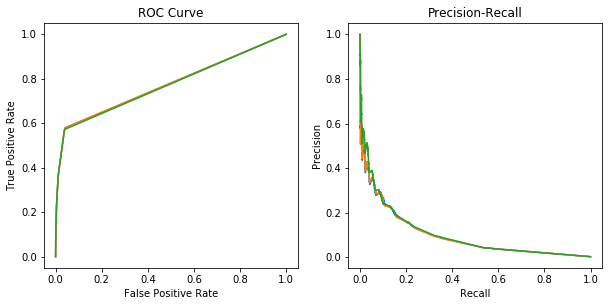

In [11]:
%%time

# Set up basic parameters and data containers
n = 3
test_size = 0.4
accuracies = []
aps = []

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4.5))

# Split the sample first
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)

for i in range(n):
    
    # Undersample the majority for train set only
    sm = SMOTE()
    X_res, y_res = sm.fit_sample(X_train, y_train)
    
    # Train RandomForest on Undersampled train set
    clf = RandomForestClassifier(max_depth=40, n_jobs=4)
    clf.fit(X_res, y_res)
    
    # Predict/score on X_test and y_test
    result = msf.score_clf(clf, X_test, y_test, X_train=X_res, y_train=y_res)
    accuracies.append(result['scores']['accuracy'])
    aps.append(result['scores']['average_precision_score'])
    
    # Plot ROC curve
    fpr = result['scores']['roc_curve'][0]
    tpr = result['scores']['roc_curve'][1]
    ax1.plot(fpr, tpr)
    ax1.set_xlabel('False Positive Rate')
    ax1.set_ylabel('True Positive Rate')
    ax1.set_title('ROC Curve')
    
    # Plot Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_test, clf.predict_proba(X_test)[:, 1])

    ax2.plot(recall, precision)
    ax2.set_xlabel('Recall')
    ax2.set_ylabel('Precision')
    ax2.set_title('Precision-Recall')

print('Average accuracy: %f +/- %f (n=%d)' % (np.mean(accuracies), np.std(accuracies), n))
print('Average AP Score: %f +/- %f (n=%d)' % (np.mean(aps), np.std(aps), n))

In [12]:
result = msf.score_clf2(clf, X_test, y_test)

In [13]:
feature_labels = data.columns[:-1]
msf.print_clf_scores2(result, trainset=False, feature_labels=feature_labels)

==== Classifier Metrics on Test Set ====
Accuracy: 0.996935
Precision: 0.302592
Recall: 0.065088
F-Score: 0.107132
Brier Score: 0.003246
Average Precision Score: 0.102387
Confusion Matrix:  [[4873307    2072]
 [  12913     899]]
--------------- Feature Importances ---------------
 1) start_month          0.417815
 2) start_dayofweek      0.143318
 3) gender               0.124208
 4) tripduration         0.109225
 5) start_hour           0.100156
 6) birth year           0.033727
 7) start_day            0.031869
 8) end station longitude 0.011647
 9) start station longitude 0.009770
10) end station latitude 0.009576
11) start station latitude 0.008688
12) start_year           0.000000


